# Working with Scikit-fem in two dimensions

All connected domains in 1d are intervals, but domains in 2d can have wildly different shapes. 
Therefore [mesh generation](https://en.wikipedia.org/wiki/Mesh_generation) is much more complicated in 2d. We are not going to discuss this. Scikit-fem can generate some simple meshes. 

In [75]:
import numpy as np
from matplotlib import pyplot as plt
import skfem as fem
import skfem.visuals.matplotlib as fem_plt

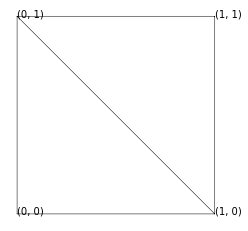

In [76]:
# Unit square
mesh = fem.MeshTri()
fem_plt.draw(mesh)
xs, ys = mesh.p # the dimensions work very nicely now!
for x, y in zip(xs, ys):
    plt.text(x, y, f'({x:.0f}, {y:.0f})')

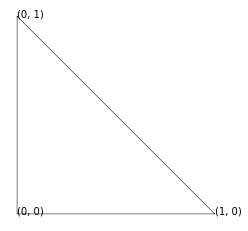

In [77]:
# The reference domain is a triangle
mesh = fem.MeshTri.init_refdom()
fem_plt.draw(mesh)
xs, ys = mesh.p
for x, y in zip(xs, ys):
    plt.text(x, y, f'({x:.0f}, {y:.0f})')

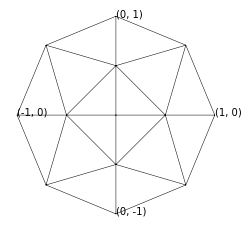

In [78]:
# Unit circle
mesh = fem.MeshTri.init_circle(nrefs=1)
fem_plt.draw(mesh)
eps = np.finfo(float).eps
xs, ys = mesh.p
for x, y in zip(xs, ys):
    # Label only a couple of points
    if ((abs(x) < eps or abs(y) < eps) 
            and (abs(abs(x) - 1) < eps or abs(abs(y) - 1) < eps)):
        plt.text(x, y, f'({x:.0f}, {y:.0f})')

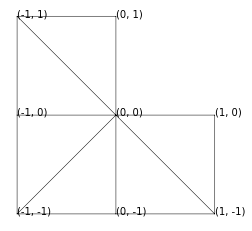

In [79]:
mesh = fem.MeshTri.init_lshaped()
fem_plt.draw(mesh)
xs, ys = mesh.p
for x, y in zip(xs, ys):
    plt.text(x, y, f'({x:.0f}, {y:.0f})')

These meshes can be transformed further, see for instance this [example](https://scikit-fem.readthedocs.io/en/latest/listofexamples.html#example-13-laplace-with-mixed-boundary-conditions). More complicated meshes can be created using [CAD](https://en.wikipedia.org/wiki/Computer-aided_design) software such as [FreeCAD](https://www.freecadweb.org/). Techniques based on signed distance functions can also be useful, see for example [sdf](https://github.com/fogleman/sdf) Python package. Here is an [example](https://scikit-fem.readthedocs.io/en/latest/listofexamples.html#example-21-structural-vibration) on how to load a mesh with Scikit-fem. However, we are only going to use the four types of basic meshes plotted above. 

Mesh refinement works as in the 1d case.

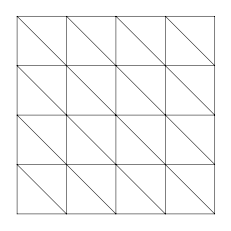

In [80]:
mesh = fem.MeshTri().refined(2)
fem_plt.draw(mesh);

# Triangles and facets

In 1d we considered nodes

\begin{align*}
0 = x_0 < x_1 < \dots < x_n = 1,
\end{align*}

and mapped the reference domain $[0,1]$ on the domains $I_e = [x_{e-1}, x_e]$, $e=1,\dots,n$.
In 2d the reference domain is the triangle with vertices $(0,0)$, $(1,0)$ and $(0,1)$,
and this is mapped on other triangles using affine functions. Note that more complicated affine functions than rigid motions and scaling are needed in the case of the circle above. 

In 1d consecutive nodes define an element domain, but in 2d we need to know explicitly which nodes form triangles. This information is stored in `mesh.t`. 

Number of nodes: mesh.nvertices = 4
Number of triangles: mesh.nelements = 2
Indices of the triples of nodes that form the triangles: mesh.t.T = 
[[0 1 2]
 [1 2 3]]


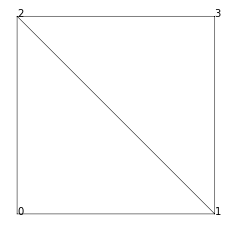

In [81]:
mesh = fem.MeshTri()
print(f'Number of nodes: {mesh.nvertices = }')
print(f'Number of triangles: {mesh.nelements = }')
# Transpose just for prettier printing
print(f'Indices of the triples of nodes that form the triangles: mesh.t.T = ') 
print(mesh.t.T)

fem_plt.draw(mesh, node_numbering=True);

The line segments forming the triangles are called facets. They are stored in `mesh.facets`.

In [82]:
print(f'Indices of the pairs of nodes that form the facets: mesh.facets.T = ') 
print(mesh.facets.T)

Indices of the pairs of nodes that form the facets: mesh.facets.T = 
[[0 1]
 [0 2]
 [1 2]
 [1 3]
 [2 3]]


# Local P1 basis functions

We can use [plot_trisurf](https://matplotlib.org/stable/tutorials/toolkits/mplot3d.html#tri-surface-plots) to plot functions given at the nodes of triangles. Let's try this for the first P1 basis function on the reference domain.

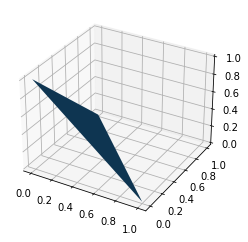

In [83]:
mesh_ref = fem.MeshTri.init_refdom()
basis_ref_P1 = fem.Basis(mesh_ref, fem.ElementTriP1())
u = np.zeros(basis_ref_P1.N) 
u[0] = 1
ax3d = plt.axes(projection='3d')
xs_mesh_ref, ys_mesh_ref = mesh_ref.p
ax3d.plot_trisurf(xs_mesh_ref, ys_mesh_ref, u, triangles=mesh_ref.t.T);

The picture can be made prettier by plotting the cross sections of the basis function over facets, and also its nodal values. 

In [84]:
import plot_basis2d as pb2
def prettify(u, basis):
    pb2.plot_facet_vals(u, basis)
    pb2.plot_nodal_vals(u, basis)
    pb2.set_equal_aspect()
    pb2.hide_ticks()

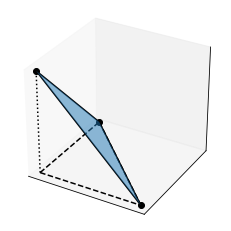

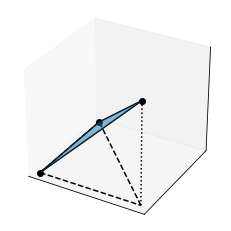

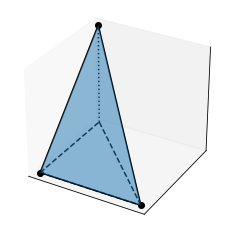

In [85]:

for j in range(basis_ref_P1.N):
    plt.figure()
    ax3d = plt.axes(projection='3d')
    u = np.zeros(basis_ref_P1.N) 
    u[j] = 1
    ax3d.plot_trisurf(xs_mesh_ref, ys_mesh_ref, u, triangles=mesh_ref.t.T, alpha=0.5, shade=False)
    prettify(u, basis_ref_P1)

# Local P2 basis functions

To capture the features of P2 basis functions, we need to refine the mesh.

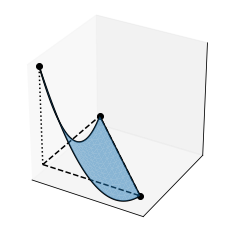

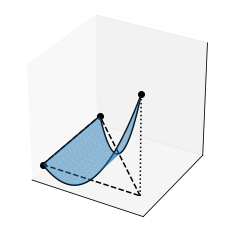

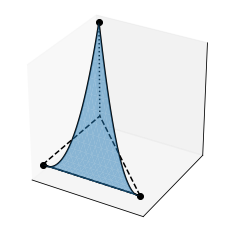

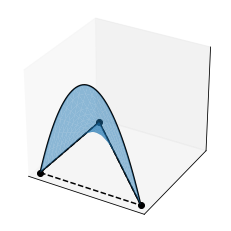

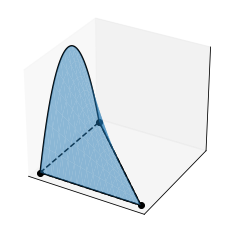

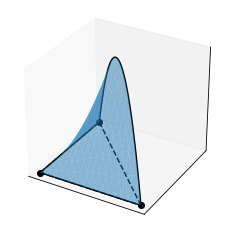

In [86]:
basis_ref_P2 = fem.Basis(mesh_ref, fem.ElementTriP2())
for j in range(basis_ref_P2.N):
    plt.figure()
    ax3d = plt.axes(projection='3d')
    u = np.zeros(basis_ref_P2.N) 
    u[j] = 1
    mesh_plot, u_plot = basis_ref_P2.refinterp(u, nrefs=4)
    xs_mesh_plot, ys_mesh_plot = mesh_plot.p
    ax3d.plot_trisurf(xs_mesh_plot, ys_mesh_plot, u_plot, triangles=mesh_plot.t.T, alpha=0.5, shade=False)
    prettify(u, basis_ref_P2)

The first three basis functions take value 1 at one of the nodes and vanish at the other nodes and at the midpoints of the facets, while the last three basis functions take value 1 at one of the midpoints and vanish at the other midpoints and at the nodes. The degrees of freedom (i.e. the coefficients in the basis) can be visualized as being located at the nodes and midpoints.  

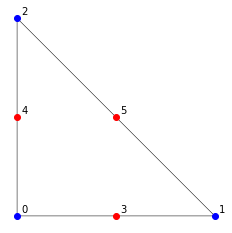

In [87]:
def plot_dof(basis, dof, style):
    x, y = basis.doflocs[:, dof]
    plt.plot(x, y, style)
    plt.annotate(str(dof), xy=(x, y), xytext=(4, 4), textcoords='offset pixels')

fem_plt.draw(mesh_ref)
for dof in np.squeeze(basis_ref_P2.nodal_dofs):
    plot_dof(basis_ref_P2, dof, 'ob')
for dof in np.squeeze(basis_ref_P2.facet_dofs):
    plot_dof(basis_ref_P2, dof, 'or')

# Global P1 basis functions

Number of basis functions: basis.N = 25


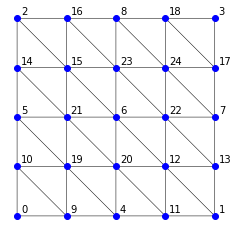

In [88]:
mesh = fem.MeshTri().refined(2)
basis = fem.Basis(mesh, fem.ElementTriP1())
print(f'Number of basis functions: {basis.N = }')
fem_plt.draw(mesh)
for dof in np.squeeze(basis.nodal_dofs):
    plot_dof(basis, dof, 'ob')

Plot the basis function in the middle.

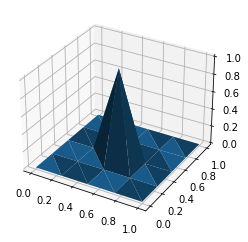

In [89]:
u = np.zeros(basis.N) 
u[6] = 1
ax3d = plt.axes(projection='3d')
xs_mesh, ys_mesh = mesh.p
ax3d.plot_trisurf(xs_mesh, ys_mesh, u, triangles=mesh.t.T);

Using [tripcolor](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tripcolor.html) we can visualize functions on top of the mesh. [Gouraud shading](https://en.wikipedia.org/wiki/Gouraud_shading) corresponds to linear interpolation of the nodal values in each triangle. This gives an accurate picture of P1 basis functions. (The shading does not use colors from the [colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) in the interpolation. This does not look too bad with the default sequential, linear colormap, but the distortion is worse for instance with diverging colormaps.)   

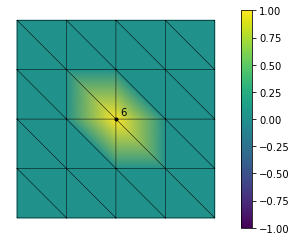

In [90]:
fem_plt.draw(mesh)
plot_dof(basis, 6, '.k')
plt.tripcolor(xs_mesh, ys_mesh, mesh.t.T, u, 
    shading='gouraud', vmin=-1, vmax=1)
plt.colorbar();

This is more or less what `plot` of Scikit-fem does. 

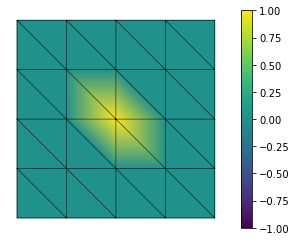

In [91]:
fem_plt.draw(mesh)
fem_plt.plot(basis, u, nrefs=0,
    shading='gouraud', vmin=-1, vmax=1, ax=plt.gca(), colorbar=True);
# plt.colorbar() does not work with plot of Scikit-fem

# Global P2 basis functions



Number of nodal dofs: np.size(basis.nodal_dofs) = 25
Number of facet dofs: np.size(basis.facet_dofs) = 56
Number of basis functions: basis.N = 81


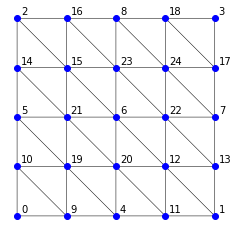

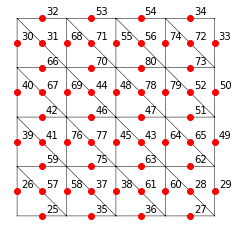

In [92]:
mesh = fem.MeshTri().refined(2)
basis = fem.Basis(mesh, fem.ElementTriP2())
print(f'Number of nodal dofs: {np.size(basis.nodal_dofs) = }')
print(f'Number of facet dofs: {np.size(basis.facet_dofs) = }')
print(f'Number of basis functions: {basis.N = }')
fem_plt.draw(mesh)
for dof in np.squeeze(basis.nodal_dofs):
    plot_dof(basis, dof, 'ob')
fem_plt.draw(mesh)
for dof in np.squeeze(basis.facet_dofs):
    plot_dof(basis, dof, 'or')

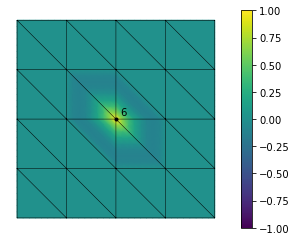

In [93]:
u = np.zeros(basis.N) 
u[6] = 1
fem_plt.draw(mesh)
plot_dof(basis, 6, '.k')
fem_plt.plot(basis, u, nrefs=3,
    shading='gouraud', vmin=-1, vmax=1, ax=plt.gca(), colorbar=True);

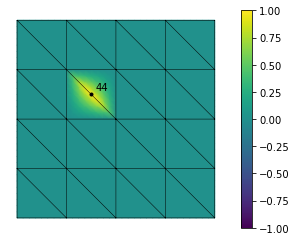

In [94]:
u = np.zeros(basis.N) 
u[44] = 1
fem_plt.draw(mesh)
plot_dof(basis, 44, '.k')
fem_plt.plot(basis, u, nrefs=3,
    shading='gouraud', vmin=-1, vmax=1, ax=plt.gca(), colorbar=True);